In [4]:
%matplotlib inline
import urllib
from bs4 import BeautifulSoup
import matplotlib
import shapefile
import pandas as pd
import re
from shapely import geometry,ops,speedups
import os
import seaborn
from collections import defaultdict
import pickle
import matplotlib.pyplot  as plt
import numpy as np
import pandas as pd
import numpy as np
import math
import shapefile
import os
import scipy as sp
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from matplotlib.patches import Circle
import glob
import shapefile
from sklearn import cluster
from collections import defaultdict
import dill
import json
import utm
from collections import defaultdict
from numpy import linalg
from itertools import combinations
from shapefile_read import get_records, grid_and_bur
from taxi_manipulations import taxi_data


In [5]:
with open("agg_data.dill","r") as f:
    agg_data = dill.load(f)

In [6]:
agg_data.cluster

{}

In [7]:
speedups.enable()


SPACING = 0.005/4

COLUMNS = [u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'RateCodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount', u'Pickup_Borough',
       u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',
       u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']
TO_USE = [u'tpep_pickup_datetime', u'tpep_dropoff_datetime', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount',u'tip_amount', u'total_amount', u'Pickup_Borough',
       u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',
       u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']


INDEX_TO_USE = [COLUMNS.index(item) for item in TO_USE]

In [8]:
sf = shapefile.Reader("new-york_new-york.imposm-shapefiles/new-york_new-york_osm_admin.shp")

names = {"Kings County":"Brooklyn","Queens County":"Queens","Richmond County":"Statten Island",
         "New York County":"Manhattan","Bronx County":"Bronx"}
ny_records = get_records(sf, names)

print "Building Grid"

nyGrid = grid_and_bur(SPACING,ny_records)

nyGrid.set_params()

Self-intersection at or near point -74.039740173399863 40.699024314884056


Building Grid


In [9]:
class agg_data(object):
    def __init__(self):
        self.rest = pd.read_csv("All_Rest.csv")
        self.cluster = {}
        self.heat_map = {} 
        self.rest["counts"] = 0
        self.MAX_VAL = 0


    def get_rest_boxes(self,grid):
        coords = self.rest[["Lat","Long"]].values
        self.rest = pd.concat([self.rest,pd.DataFrame({"grid":map(lambda x:grid.get_index(*x),coords)})],axis = 1)

    def initialize_heat_map(self):
        for t in np.arange(0,24,0.5):
            self.heat_map[t] = np.zeros(shape = nyGrid.relevant.shape)

    def normalize_cmap(self):
        for key in self.heat_map:
            self.heat_map[key] = np.log(np.log(self.heat_map[key]+1)+1)/self.MAX_VAL


TOTAL_DATA = agg_data()
TOTAL_DATA.initialize_heat_map()
TOTAL_DATA.get_rest_boxes(nyGrid)

In [10]:
df = pd.read_csv("https://storage.googleapis.com/taxi_ben/yellow_2015_01.csv", usecols=INDEX_TO_USE)

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
 df.columns = ["pickup_datetime", "dropoff_datetime", "trip_distance",\
"pickup_long","pickup_lat","dropoff_long","dropoff_lat", \
"payment_type","fare_amount","tip_amount","total_amount",u'Pickup_Borough',
       u'Pickup_Neighbourhood', u'Pickup_Zip_code', u'Dropoff_Borough',
       u'Dropoff_Neighbourhood', u'Dropoff_Zip_code']

In [13]:
data = taxi_data(df, nyGrid,"01")

In [14]:
print "Converting datetime"
data.convert_datetime()

Converting datetime


In [15]:
print "Adding Details"
data.add_details()

Adding Details


In [16]:
print "Cleaning Data"
data.clean_data()

Cleaning Data


In [17]:
print "Setting Boxes"
data.set_boxes()

Setting Boxes


In [27]:
for name,g in data.df.groupby("half_hour"):
    g2 = g.groupby("drop_grid").agg('size')
    g2.index

In [15]:
print "Updataing Heatmap"
data.update_heat_map(TOTAL_DATA)

Updataing Heatmap


In [18]:
print "Clustering"
data.perform_clustering(TOTAL_DATA)

Clustering


In [20]:
TOTAL_DATA.cluster

{}

In [30]:
perform_clustering(data.df,TOTAL_DATA)

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
def perform_clustering(df, agg_data):
    groups_to_use = ["Pickup_Borough","pickup_month","pickup_day","time_category_pick"]

    for name,group in df.groupby(by = groups_to_use):
        if name[0] == "Manhattan":
            eps = 80
            throttle = 0.0025
        else:
            eps = 150
            throttle = 0.005




        coords_pick = map(lambda x: utm.from_latlon(*x)[:2],zip(group.pickup_lat.values, group.pickup_long.values))
        min_samples = max(4,len(coords_pick)*throttle)
        dbScan = cluster.DBSCAN(eps = eps, min_samples= min_samples, metric = "euclidean")
        result = dbScan.fit_predict(coords_pick)
        group["result"] = result
        g2 = group[["pickup_lat","pickup_long","fare_amount","payment_type","duration","result"]].groupby("result")
        temp = []
        for name2,group2 in g2:
            if name2 != -1: 
                poly = geometry.MultiPoint(group2[["pickup_long","pickup_lat"]].values).convex_hull
                count_vals = len(group2["pickup_lat"])
                g2card = group2[group2["payment_type"] ==1]
                if g2card.size > 0:
                    mean_tip = g2card["fare_amount"].sum()/float(g2card["duration"].sum().seconds/60.0)
                else:
                    mean_tip = 0
                temp.append([poly,count_vals,mean_tip])
        if temp:#yield temp

            dfTemp = pd.DataFrame(temp, columns = ["poly","counts","percent"])
            dfTemp["normalized"] = dfTemp["percent"]*(dfTemp["counts"]/dfTemp["counts"].sum())
            dfTemp["normalized"] = dfTemp["normalized"]/(dfTemp["normalized"].max()+0.0000001)
            name_of_group = tuple(["01"] + list(name))
            agg_data.cluster[name_of_group] = dfTemp
            del dfTemp


In [ ]:
groups_to_use = ["Pickup_Borough","pickup_month","pickup_day","time_category_pick"]

for name,group in data.df.groupby(by = groups_to_use):
    if name[0] == "Manhattan":
        eps = 80
        throttle = 0.0025
    else:
        eps = 150
        throttle = 0.005




    coords_pick = map(lambda x: utm.from_latlon(*x)[:2],zip(group.pickup_lat.values, group.pickup_long.values))
    min_samples = max(4,len(coords_pick)*throttle)
    dbScan = cluster.DBSCAN(eps = eps, min_samples= min_samples, metric = "euclidean")
    result = dbScan.fit_predict(coords_pick)
    group["result"] = result
    g2 = group[["pickup_lat","pickup_long","payment_type","fare_amount","duration","result"]].groupby("result")
    temp = []
    for name2,group2 in g2:
        if name2 != -1: 
            poly = geometry.MultiPoint(group2[["pickup_long","pickup_lat"]].values).convex_hull
            count_vals = len(group2["pickup_lat"])
            g2card = group2[group2["payment_type"] ==1]
            if g2card.size > 0:
                mean_tip = g2card["fare_amount"].sum()/float(g2card["duration"].sum().seconds/60.0)
            else:
                mean_tip = 0
            temp.append([poly,count_vals,mean_tip])
    if temp:#yield temp

        dfTemp = pd.DataFrame(temp, columns = ["poly","counts","percent"])
        dfTemp["normalized"] = dfTemp["percent"]*(dfTemp["counts"]/dfTemp["counts"].sum())
        dfTemp["normalized"] = dfTemp["normalized"]/(dfTemp["normalized"].max()+0.0000001)
        name_of_group = tuple([data.name] + list(name))
        TOTAL_DATA.cluster[name_of_group] = dfTemp
        del dfTemp

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Exception KeyboardInterrupt in <bound method Polygon.__del__ of <shapely.geometry.polygon.Polygon object at 0x7f750db432d0>> ignored
Exception KeyboardInterrupt in <bound method Polygon.__del__ of <shapely.geometry.polygon.Polygon object at 0x7f750db06790>> ignored
Exception KeyboardInterrupt in <bound method Polygon.__del__ of <shapely.geometry.polygon.Polygon object at 0x7f750db06d50>> ignored
Exception KeyboardInterrupt in <bound method Polygon.__del__ of <shapely.geometry.polygon.Polygon object at 0x7f750db06e90>> ignored
Exception KeyboardInterrupt in <bound method Polygon.__del__ of <shapely.geometry.polygon.Polygon object at 0x7f750dae7a10>> ignored

KeyboardInterrupt: 

In [14]:
data.df["bur"] = 0

In [232]:
burs = data.df.bur.iloc[:,1]

In [233]:
data.df["burs"] = burs

In [234]:
data.df.head()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,payment_type,fare_amount,tip_amount,total_amount,pickup_month,pickup_day,duration,time_category_pick,nearest_pick,half_hour,bur,bur,burs
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1.59,-73.993896,40.750111,-73.974785,40.750618,1.0,12.0,3.25,17.05,1.0,3.0,00:18:03,19.0,5.0,19.0,0.0,Manhattan,Manhattan
1,2015-01-10 20:33:38,2015-01-10 20:53:28,3.30,-74.001648,40.724243,-73.994415,40.759109,1.0,14.5,2.00,17.80,1.0,5.0,00:19:50,20.0,35.0,20.5,0.0,Manhattan,Manhattan
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1.80,-73.963341,40.802788,-73.951820,40.824413,2.0,9.5,0.00,10.80,1.0,5.0,00:10:03,20.0,35.0,20.5,0.0,Manhattan,Manhattan
3,2015-01-10 20:33:39,2015-01-10 20:35:31,0.50,-74.009087,40.713818,-74.004326,40.719986,2.0,3.5,0.00,4.80,1.0,5.0,00:01:52,20.0,35.0,20.5,0.0,Manhattan,Manhattan
4,2015-01-10 20:33:39,2015-01-10 20:52:58,3.00,-73.971176,40.762428,-74.004181,40.742653,2.0,15.0,0.00,16.30,1.0,5.0,00:19:19,20.0,35.0,20.5,0.0,Manhattan,Manhattan


In [15]:
print "Clustering"
data.perform_clustering(TOTAL_DATA)





Clustering


NameError: global name 'geometry' is not defined

In [14]:
data.df.columns

Index([      u'pickup_datetime',      u'dropoff_datetime',
               u'trip_distance',           u'pickup_long',
                  u'pickup_lat',          u'dropoff_long',
                 u'dropoff_lat',          u'payment_type',
                 u'fare_amount',            u'tip_amount',
                u'total_amount',        u'Pickup_Borough',
        u'Pickup_Neighbourhood',       u'Pickup_Zip_code',
             u'Dropoff_Borough', u'Dropoff_Neighbourhood',
            u'Dropoff_Zip_code',          u'pickup_month',
                  u'pickup_day',              u'duration',
          u'time_category_pick',          u'nearest_pick',
                   u'half_hour'],
      dtype='object')

In [15]:
groups_to_use = ["Pickup_Borough","pickup_month","pickup_day","time_category_pick"]
g = data.df.groupby(by = groups_to_use)

In [16]:
gg = g.get_group(("Brooklyn" ,1.0, 0.0, 22.0))

In [17]:
gg.head()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,payment_type,fare_amount,tip_amount,...,Pickup_Zip_code,Dropoff_Borough,Dropoff_Neighbourhood,Dropoff_Zip_code,pickup_month,pickup_day,duration,time_category_pick,nearest_pick,half_hour
15074,2015-01-19 22:13:14,2015-01-19 22:20:58,1.35,-73.982529,40.678318,-73.968422,40.683872,2,7.5,0.0,...,11217,Brooklyn,Central Brooklyn,11238,1,0,00:07:44,22,15,22.0
16133,2015-01-05 22:38:29,2015-01-05 22:39:28,5.10,-73.954544,40.731976,-73.954529,40.731968,2,2.5,0.0,...,11222,Brooklyn,Greenpoint,11222,1,0,00:00:59,22,40,22.5
18683,2015-01-12 22:20:08,2015-01-12 22:24:50,0.97,-73.954971,40.688267,-73.947952,40.682045,1,5.5,1.5,...,11216,Brooklyn,Central Brooklyn,11216,1,0,00:04:42,22,20,22.0
29315,2015-01-05 22:01:59,2015-01-05 22:12:00,1.86,-73.947960,40.711288,-73.927452,40.692532,2,9.0,0.0,...,11211,Brooklyn,Bushwick and Williamsburg,11221,1,0,00:10:01,22,0,22.0
40748,2015-01-19 22:28:57,2015-01-19 22:39:07,3.73,-73.957832,40.714600,-73.899940,40.738552,1,13.0,2.7,...,11211,Queens,West Queens,11377,1,0,00:10:10,22,30,22.5


In [35]:
throttle = 0.005

In [36]:
coords_pick = map(lambda x: utm.from_latlon(*x)[:2],zip(gg.pickup_lat.values, gg.pickup_long.values))
min_samples = int(max(4,len(coords_pick)*throttle))


In [37]:
min_samples

6

In [44]:
dbScan = cluster.DBSCAN(eps = 150, min_samples= min_samples, metric = "euclidean")
result = dbScan.fit_predict(coords_pick)

In [45]:
gg["result"] = result

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [46]:
g2 = gg[["pickup_lat","pickup_long","payment_type","tip_amount","fare_amount","result"]].groupby("result")
temp = []

In [47]:
for name2,group2 in g2:
    if name2 != -1: 
        poly = geometry.MultiPoint(group2[["pickup_long","pickup_lat"]].values).convex_hull
        count_vals = len(group2["pickup_lat"])
        g2card = group2[group2["payment_type"] ==1]
        mean_tip = g2card["tip_amount"].sum()/float(g2card["fare_amount"].sum())
        temp.append([poly,count_vals,mean_tip])

In [48]:
from descartes import PolygonPatch

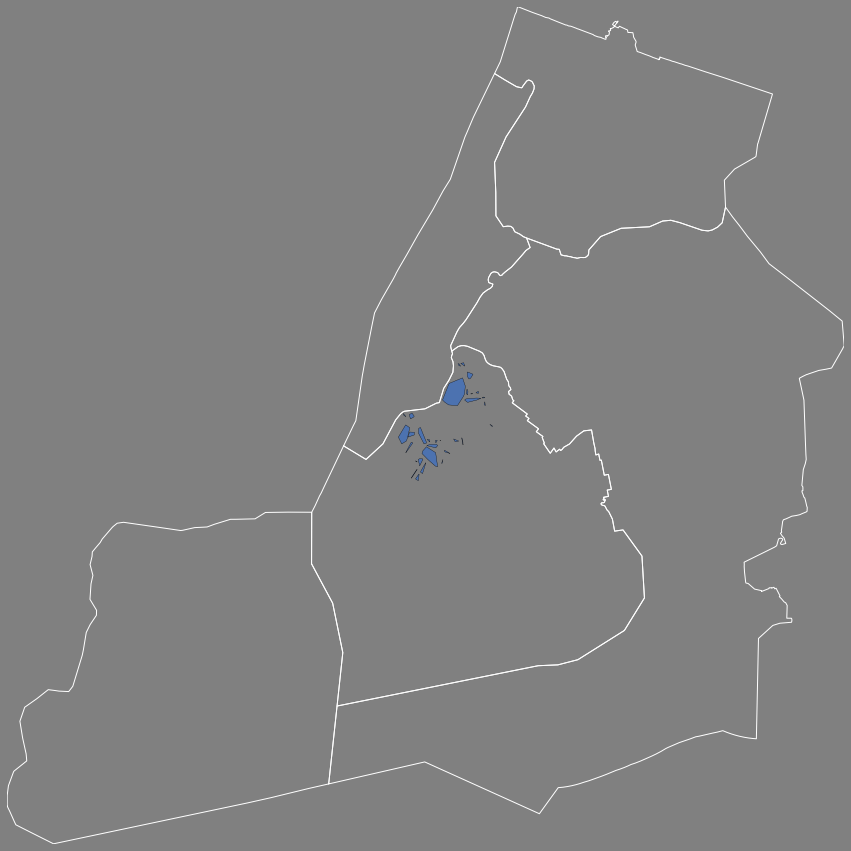

In [49]:
cmap = sns.dark_palette('#f7b731', as_cmap=True)
fig = plt.figure(figsize=(15,15), dpi=1000)
ax1 = fig.add_subplot(111)
sns.despine(fig)
sns.set_style("dark")
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})

ax1 = fig.gca()
ax1.set_yticks([])
ax1.set_xticks([])

#ax2 = fig.add_subplot(212)
for poly in ny_records.values():
#     x1, y1 = poly[0].exterior.xy
#     ax1.plot(x1, y1)
    try:
        x2, y2 = poly.exterior.xy
        ax1.plot(x2, y2,"white",lw = 1)
    except AttributeError:
        for poly in poly:
            x2,y2 = poly.exterior.xy
            ax1.plot(x2,y2,"white",lw = 1)
# ax = fig.gca()
for row in temp:
    #color = cmap(row[2])
    ax1.add_patch(PolygonPatch(row[0], fill=True))
# x = gg["pickup_lat"].values
# y = gg["pickup_long"].values

# for i in range(len(x)):
#     ax1.scatter(y[i],x[i])

plt.plot();

In [19]:
TOTAL_DATA.cluster

{}

In [292]:
nyGrid.get_burough((x[0],y[0]))

'Manhattan'

In [286]:
y[0]

-73.988639831542983